### **To-Do List:**

1. Look into which other parts of the code I can turn into functions/modules. 
   
2. Find where I can meaningfully test with pytest (see [here](https://realpython.com/python-testing/) and [here](https://coderefinery.github.io/testing/)).
   
 --> **Read articles, how much of this should I immediately go into? Installed pytest, confirmed it works with:
 "pytest -v tests/test.py", looking for practical things to test.**

3. Make package pip-installable, as per the instructions [here](https://aaltoscicomp.github.io/python-for-scicomp/packaging/). 
  
  --> **Added pyproject.toml, made it Git-ignorable, haven't tested local pip install yet.**

4. More detailed README and module documentation, based on recommendations [here](https://coderefinery.github.io/documentation/). **Can GitHub Copilot help?**

5. Add LICENSE file (https://github.com/coderefinery/social-coding/blob/main/licensing-and-cakes.md).

**Warnings:**

- FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))

--> **Seems like different types are being concatenated and this warning is triggered, but it's fine for now. Track future Pandas developments. It's also possible the NaN values are because I am not specifying any noise level (NaN column).**

- c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py
  
FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object. args["df"] = pd.read_json(args["df"]["value"], dtype=False)

--> In data.py, I replaced this:

        if "df" in args and not isinstance(args["df"], pd.DataFrame):
            # NOTE: Need dtype=False, otherwise infers arm_names like
            # "4_1" should be int 41.
            args["df"] = pd.read_json(args["df"]["value"], dtype=False)

with this:

        import io
        if "df" in args and not isinstance(args["df"], pd.DataFrame):
            # Wrap the JSON string in a StringIO object and use pd.io.json.read_json
            args["df"] = pd.io.json.read_json(io.StringIO(args["df"]["value"]), dtype=False)
        return extract_init_args(args=args, class_=cls)

--> **Fixed.**

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models

### Training Data and Parameters

In [2]:
unique_parameters = ["tungstate_concentration", "current_density", "deposition_time", "pH"] 
# temperature avoided, kept constant at 25 C

# EXAMPLE, here use actual data
X_train = np.array([[0.05, 10, 500, 5],
               [0.05, 50, 300, 6],
               [0.1, 10, 300, 7],
               [0.1, 10, 600, 8],
               
               [0.1, 50, 600, 7.5],
               [0.1, 100, 600, 10],
               [0.1, 50, 400, 6.5],
               [0.1, 30, 600, 8.5],
               [0.15, 10, 600, 9.5],
               [0.15, 50, 300, 9.5],
               
               # NEW OPTIMIZATION DATA    
               ])

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns=unique_parameters)
X_train

,tungstate_concentration,current_density,deposition_time,pH
0,0.05,10.0,500.0,5.0
1,0.05,50.0,300.0,6.0
2,0.10,10.0,300.0,7.0
3,0.10,10.0,600.0,8.0
4,0.10,50.0,600.0,7.5
5,0.10,100.0,600.0,10.0
6,0.10,50.0,400.0,6.5
7,0.10,30.0,600.0,8.5
8,0.15,10.0,600.0,9.5
9,0.15,50.0,300.0,9.5


In [3]:
# Number of data points
n_train = X_train.shape[0]

unique_objectives = ["overpotential", "overpotential_slope"]

# EXAMPLE, here use actual observations
y_train = np.array([[-358,0.00015], 
                    [-319,0.000066], 
                    [-377,0.0001], 
                    [-319,-0.000518],
                    [-286,0.00008], 
                    [-312,0.000029], 
                    [-309,-0.000057], 
                    [-290,0.001656],
                    [-329,0.000131], 
                    [-305,-0.000064],

                    # NEW OPTIMIZATION DATA                    
                    ])

# Convert to dataframe
y_train = pd.DataFrame(y_train, columns=unique_objectives)
y_train

,overpotential,overpotential_slope
0,-358.0,0.000150
1,-319.0,0.000066
2,-377.0,0.000100
3,-319.0,-0.000518
4,-286.0,0.000080
5,-312.0,0.000029
6,-309.0,-0.000057
7,-290.0,0.001656
8,-329.0,0.000131
9,-305.0,-0.000064


In [4]:
parameters = [
    {
        "name": "tungstate_concentration",
        "type": "range",
        "bounds": [0.05, 0.2],
        "value_type": "float"  
    },
    {
        "name": "current_density",
        "type": "range",
        "bounds": [5, 125],
        "value_type": "int"  
    },
    {
        "name": "deposition_time",
        "type": "range",
        "bounds": [60, 600],
        "value_type": "int"  
    },
    {
        "name": "pH",
        "type": "range",
        "bounds": [5, 10],
        "value_type": "int"  
    }
]

### Generation Strategy 

In [5]:
# Specify a custom generation strategy - Skips the pseudo-random initial suggested points 
gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model = Models.MOO, 
            # Uses qNEHVI by default, instead of GPEI (for single) and PAREGO (for multi but worse than qNEHVI)
            # Not passing any information about the observation noise; so the model is inferring a Gaussian noise level on the observations - SingleTaskGP
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=3  # BATCH/Parallelism limit for this step, often lower than for Sobol
                    )
            ]
)

### Setup the experiment

In [6]:
ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="NiW",
    parameters=parameters,
    objectives={
        "overpotential": ObjectiveProperties(minimize=False, threshold = -350), # How ambitious + what is max (min) allowable value?
        "overpotential_slope": ObjectiveProperties(minimize=False, threshold = -0.001) # Not clear, looking for >=0 if possible
    },
    overwrite_existing_experiment=False, # To make sure my progress is being saved
    is_test = False, # Set this to False when running a REAL experiment
    choose_generation_strategy_kwargs = {"max_parallelism_override": 3} # Parallel/Batch evaluation, max batch size = 3
)

[INFO 02-09 22:34:53] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-09 22:34:53] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='tungstate_concentration', parameter_type=FLOAT, range=[0.05, 0.2]), RangeParameter(name='current_density', parameter_type=INT, range=[5, 125]), RangeParameter(name='deposition_time', parameter_type=INT, range=[60, 600]), RangeParameter(name='pH', parameter_type=INT, range=[5, 10])], parameter_constraints=[]).


### Input training data & Instantiate model (run this only the FIRST time)

In [7]:
from src.ax_code.attach_training_data import attach_training_data
attach_training_data(ax_client, X_train, y_train, unique_objectives)

[INFO 02-09 22:34:55] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 10, 'deposition_time': 500, 'pH': 5}] as trial 0.
[INFO 02-09 22:34:55] ax.service.ax_client: Completed trial 0 with data: {'overpotential': (-358.0, None), 'overpotential_slope': (0.00015, None)}.
[INFO 02-09 22:34:55] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 50, 'deposition_time': 300, 'pH': 6}] as trial 1.
[INFO 02-09 22:34:55] ax.service.ax_client: Completed trial 1 with data: {'overpotential': (-319.0, None), 'overpotential_slope': (6.6e-05, None)}.
[INFO 02-09 22:34:55] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.1, 'current_density': 10, 'deposition_time': 300, 'pH': 7}] as trial 2.
[INFO 02-09 22:34:55] ax.service.ax_client: Completed trial 2 with data: {'overpotential': (-377.0, None), 'overpotential_slope': (0.0001, None)}.
[INFO 02-09 22:34:

In [8]:
# Instantiate the first model
ax_client.fit_model()
print('model:', ax_client.generation_strategy.model)

[INFO 02-09 22:34:56] ax.service.ax_client: get_model_predictions() has been called when no model is instantiated. Attempting to instantiate the model for the first time.
[INFO 02-09 22:34:56] ax.service.ax_client: Successfully instantiated a model for the first time.
[INFO 02-09 22:34:56] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


model: <ax.modelbridge.torch.TorchModelBridge object at 0x0000029ADEA6EE30>


### Run optimization and get next suggestions 

In [9]:
# Generate a batch of 3 new trials
for i in range(3): 
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

[INFO 02-09 22:34:58] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.
[INFO 02-09 22:35:01] ax.service.ax_client: Generated new trial 10 with parameters {'tungstate_concentration': 0.098546, 'current_density': 48, 'deposition_time': 600, 'pH': 9}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-09 22:35:01] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.0985460500369825, 'current_density': 48, 'deposition_time': 600, 'pH': 9}


[INFO 02-09 22:35:05] ax.service.ax_client: Generated new trial 11 with parameters {'tungstate_concentration': 0.062687, 'current_density': 42, 'deposition_time': 600, 'pH': 8}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-09 22:35:05] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.06268740896315327, 'current_density': 42, 'deposition_time': 600, 'pH': 8}


[INFO 02-09 22:35:09] ax.service.ax_client: Generated new trial 12 with parameters {'tungstate_concentration': 0.141009, 'current_density': 47, 'deposition_time': 600, 'pH': 8}.


next suggested experiment:  {'tungstate_concentration': 0.14100944799286003, 'current_density': 47, 'deposition_time': 600, 'pH': 8}


In [10]:
# Confirm running trials
ax_client.generation_strategy.trials_as_df

[INFO 02-09 22:36:01] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,GenerationStep_0,MOO,10,RUNNING,"{'10_0': {'tungstate_concentration': 0.1, 'cur..."
1,GenerationStep_0,MOO,11,RUNNING,"{'11_0': {'tungstate_concentration': 0.06, 'cu..."
2,GenerationStep_0,MOO,12,RUNNING,"{'12_0': {'tungstate_concentration': 0.14, 'cu..."


### Perform lab experiments and get new objectives

In [11]:
# Complete pendings trials
# We manually set SEM = None to indicate that we know the function to be noisy, but would like Ax to estimate the noise for us.
ax_client.complete_trial(trial_index=10, raw_data={'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)})
ax_client.complete_trial(trial_index=11, raw_data={'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)})
ax_client.complete_trial(trial_index=12, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)})

[INFO 02-09 22:36:04] ax.service.ax_client: Completed trial 10 with data: {'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)}.
[INFO 02-09 22:36:04] ax.service.ax_client: Completed trial 11 with data: {'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)}.
[INFO 02-09 22:36:04] ax.service.ax_client: Completed trial 12 with data: {'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)}.


In [12]:
# Confirm completed trials
ax_client.generation_strategy.trials_as_df

[INFO 02-09 22:36:05] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,GenerationStep_0,MOO,10,COMPLETED,"{'10_0': {'tungstate_concentration': 0.1, 'cur..."
1,GenerationStep_0,MOO,11,COMPLETED,"{'11_0': {'tungstate_concentration': 0.06, 'cu..."
2,GenerationStep_0,MOO,12,COMPLETED,"{'12_0': {'tungstate_concentration': 0.14, 'cu..."


#### Confirm model instantiation again

In [13]:
ax_client.fit_model()
print('model:', ax_client.generation_strategy.model)

model: <ax.modelbridge.torch.TorchModelBridge object at 0x0000029ADEA6EE30>


#### Repeat as neeeded

In [ ]:
for i in range(3): # generate a batch of 3 new trials
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

In [ ]:
ax_client.complete_trial(trial_index=13, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.002, None)})
ax_client.complete_trial(trial_index=14, raw_data={'overpotential': (-259.0, None), 'overpotential_slope': (+0.00004, None)})
ax_client.complete_trial(trial_index=15, raw_data={'overpotential': (-269.0, None), 'overpotential_slope': (-0.0034, None)})

In [ ]:
ax_client.generation_strategy.trials_as_df

In [ ]:
ax_client.fit_model()
print('model:', ax_client.generation_strategy.model)

### Save/Load the experiment

In [14]:
# Save the experiment state to disk.
ax_client.save_to_json_file("ax_client_snapshot.json")  

[INFO 02-09 22:36:12] ax.service.ax_client: Saved JSON-serialized state of optimization to `ax_client_snapshot.json`.


In [15]:
# Restore the experiment state from disk.  
ax_client = AxClient.load_from_json_file("ax_client_snapshot.json") 
# For custom filepath, pass `filepath` argument.
# For any loading issues: https://github.com/facebook/Ax/issues/1565

[INFO 02-09 22:36:12] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


In [17]:
# Show all available data
ax_client.experiment.fetch_data().df

,arm_name,metric_name,mean,sem,trial_index
0,0_0,overpotential,-358.000000,NaN,0
1,0_0,overpotential_slope,0.000150,NaN,0
2,1_0,overpotential,-319.000000,NaN,1
3,1_0,overpotential_slope,0.000066,NaN,1
4,2_0,overpotential,-377.000000,NaN,2
5,2_0,overpotential_slope,0.000100,NaN,2
6,3_0,overpotential,-319.000000,NaN,3
7,3_0,overpotential_slope,-0.000518,NaN,3
8,4_0,overpotential,-286.000000,NaN,4
9,4_0,overpotential_slope,0.000080,NaN,4


### Get Pareto optimal parameters

In [16]:
pareto_optimal_params = ax_client.get_pareto_optimal_parameters(use_model_predictions=True) 
# use_model_predictions=True by default, also try False?
print("Pareto optimal parameters:", pareto_optimal_params)

Pareto optimal parameters: OrderedDict([(7, ({'tungstate_concentration': 0.1, 'current_density': 30, 'deposition_time': 600, 'pH': 8}, ({'overpotential': -287.04258392792804, 'overpotential_slope': 0.0008264057875902431}, {'overpotential': {'overpotential': 62.62297423014495, 'overpotential_slope': 0.0}, 'overpotential_slope': {'overpotential': 0.0, 'overpotential_slope': 9.73291281365827e-07}}))), (4, ({'tungstate_concentration': 0.1, 'current_density': 50, 'deposition_time': 600, 'pH': 7}, ({'overpotential': -282.3060336909546, 'overpotential_slope': 0.00019292754544286217}, {'overpotential': {'overpotential': 64.55854746658517, 'overpotential_slope': 0.0}, 'overpotential_slope': {'overpotential': 0.0, 'overpotential_slope': 1.3616222561670561e-06}}))), (12, ({'tungstate_concentration': 0.14100944799286003, 'current_density': 47, 'deposition_time': 600, 'pH': 8}, ({'overpotential': -251.17794063772214, 'overpotential_slope': -0.00037691933938424236}, {'overpotential': {'overpotential

c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\modelbridge\modelbridge_utils.py:707: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


### Plot (Posterior) Pareto front 

In [17]:
# Plotting imports and initialization
from ax.utils.notebook.plotting import render
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier

In [18]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["overpotential", "overpotential_slope"],
    num_points=16
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

### Hypervolume: Evaluating the Quality of the Pareto Front

#### For specific trial

In [23]:
from src.ax_code.hypervolume import get_hypervolume, plot_hypervolume_trace

# Get hypervolume with model predictions
trial_indices = [12]
model_true = get_hypervolume(ax_client, trial_indices, True)
print(f'Hypervolume With Model Predictions: {model_true}, For trial: {trial_indices}')

# Get hypervolume without model predictions
model_false = get_hypervolume(ax_client, trial_indices, False)
print(f'Hypervolume Without Model Predictions: {model_false}, For trial: {trial_indices}')

Hypervolume With Model Predictions: 0.1400314631171356, For trial: [12]
Hypervolume Without Model Predictions: 0.063, For trial: [12]


c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\modelbridge\modelbridge_utils.py:707: UserWarning:

FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.

c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\modelbridge\modelbridge_utils.py:707: UserWarning:

FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no act

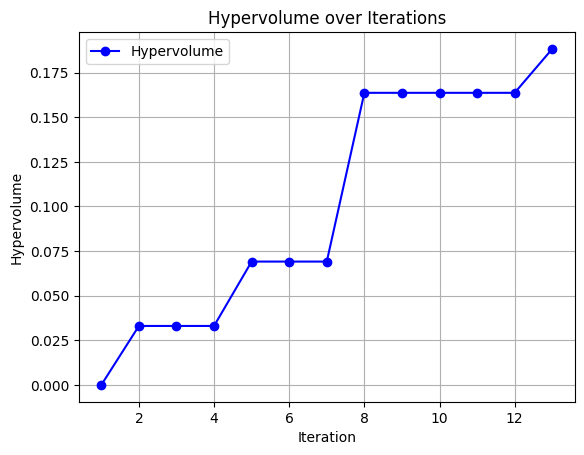

In [27]:
# Plot Hypervolume trace = Optimization trace for MOO
plot_hypervolume_trace(ax_client)

## Visualizations

In [ ]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.contour import interact_contour
from ax.plot.scatter import plot_objective_vs_constraints
from ax.plot.slice import plot_slice

#### Cross validation

In [ ]:
model = ax_client.generation_strategy.model
cv_results = cross_validate(model, folds= -1) # default folds
render(interact_cross_validation(cv_results))

#### Contour plot

In [ ]:
# Interactive contour plots, able to switch between different parameter-objective combinations.
render(interact_contour(model, metric_name="overpotential"))

#### Tradeoff plot 

In [ ]:
render(plot_objective_vs_constraints(model, "overpotential", rel=False)) # rel = False

#### Slice plot

In [ ]:
# Slice plot, can be done for all different parameter-objective combinations.
render(plot_slice(model, "pH", "overpotential"))

## More visualizations

MAKE THIS A FUNCTION

Automatic data conversion from the Ax dataframe to a list, for visualization purposes.

In [ ]:
# Get dataframe and drop the 'sem' column
data_df = ax_client.experiment.fetch_data().df
data_df = data_df.drop(columns=['sem'])

# Convert the DataFrame to a list of lists
data_list = []

for trial in data_df['trial_index'].unique():
    trial_data = data_df[data_df['trial_index'] == trial]
    
    # Extract data for 'overpotential' and 'overpotential_slope'
    overpotential_data = trial_data.loc[trial_data['metric_name'] == 'overpotential', 'mean'].tolist()[0]
    slope_data = trial_data.loc[trial_data['metric_name'] == 'overpotential_slope', 'mean'].tolist()[0]
    
    # Combine the data into a list of tuples
    trial_data_list = [overpotential_data, slope_data]
    
    # Extend the main list
    data_list.append(trial_data_list)

# Now data_list has the format I want
print(data_list)

### Plot by batch or by trial

In [ ]:
from src.ax_code.visualizations import plot_pareto

# Need to be manually organized by batch, see visualizations.py 
# (needed for the 'by batch' plot, doesn't matter for the rest)

# Choose the visualization type ('batch' or 'trial')
visualization_type = 'batch' 

# Call the function to plot the Pareto front
plot_pareto(data_list, visualization_type)

### Plot by tracking one of the two objectives over the trials

In [ ]:
from src.ax_code.visualizations import plot_pareto_objective

# Choose the visualization type ('value' or 'slope')
visualization_type = 'slope' 

# Call the function to plot the Pareto front based on tracking the chosen objective
plot_pareto_objective(data_list, visualization_type)